In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import os

In [3]:
directory = 'Rep 6'
if not os.path.exists(directory):
    # Create the directory
    os.makedirs(directory)
    
# Delete all files in the directory
#for filename in os.listdir(directory):
#    file_path = os.path.join(directory, filename)
#    try:
#        if os.path.isfile(file_path) or os.path.islink(file_path):
#            os.unlink(file_path)
#        elif os.path.isdir(file_path):
#            shutil.rmtree(file_path)
#    except Exception as e:
#        print(f'Failed to delete {file_path}. Reason: {e}')'''

In [4]:
df = pd.DataFrame({'Time (s)':[20,40,60,80],
                     'Voltage (V)':[2.701, 2.643, 2.581, 2.518],
                     'Temperature 1 (Celsius)':[34,34,35,36],
                     'Temperature 2 (Celsius)':[34, 35,35,36],
                     'Temperature 3 (Celsius)':[34,35,36,36]})

df

,Time (s),Voltage (V),Temperature 1 (Celsius),Temperature 2 (Celsius),Temperature 3 (Celsius)
0,20,2.701,34,34,34
1,40,2.643,34,35,35
2,60,2.581,35,35,36
3,80,2.518,36,36,36


In [5]:
# Function to add jitter to duplicates
def jitter(df):
    data = df.copy()
    def add_jitter(series):
        # Get counts of duplicated values
        duplicate_counts = series.duplicated(keep=False).groupby(series).transform('sum')
        
        # Create an array of zeros for jitter
        jitter = np.zeros_like(series, dtype=float)
        
        # Iterate over each unique value that has duplicates
        for value in series[series.duplicated(keep=False)].unique():
            # Get the indices of the duplicates
            indices = series[series == value].index
            
            # Number of duplicates (including the original)
            n = len(indices)
            
            # Add jitter based on relative position
            for i, idx in enumerate(indices, start=1):
                jitter[idx] = np.random.uniform((i-1)/n, (1/n) * i)
        
        # Return the series with added jitter
        return series + np.round(jitter,3)
    
    # Apply jitter to each temperature column
    data['Temperature 1 (Celsius)'] = add_jitter(data['Temperature 1 (Celsius)'])
    data['Temperature 2 (Celsius)'] = add_jitter(data['Temperature 2 (Celsius)'])
    data['Temperature 3 (Celsius)'] = add_jitter(data['Temperature 3 (Celsius)'])
    return data

jitter(df)

,Time (s),Voltage (V),Temperature 1 (Celsius),Temperature 2 (Celsius),Temperature 3 (Celsius)
0,20,2.701,34.442,34.000,34.000
1,40,2.643,34.680,35.353,35.000
2,60,2.581,35.000,35.602,36.155
3,80,2.518,36.000,36.000,36.898


In [6]:
from scipy.optimize import curve_fit
# Linear Relationship

def linear_function(x, m, b):
    return m*x + b

x = df['Time (s)']
y = df['Voltage (V)']

params, _ = curve_fit(linear_function, x, y)
V0 = np.round(params[1],3)
print(f'Voltage at t=0: {V0:.3f}V')
#plt.scatter(data['Time (s)'], data['Voltage (V)'])

Voltage at t=0: 2.763V


In [7]:
def add_first_row(df):
    data = jitter(df)
    starting_data = pd.DataFrame({'Time (s)':[0],
                         'Voltage (V)':[V0],
                         'Temperature 1 (Celsius)':[33],
                         'Temperature 2 (Celsius)':[33],
                         'Temperature 3 (Celsius)':[33]})

    data = pd.concat([starting_data, data], ignore_index=True)
    return data

data = add_first_row(df)
data

,Time (s),Voltage (V),Temperature 1 (Celsius),Temperature 2 (Celsius),Temperature 3 (Celsius)
0,0,2.763,33.000,33.000,33.000
1,20,2.701,34.172,34.000,34.000
2,40,2.643,34.740,35.063,35.000
3,60,2.581,35.000,35.920,36.135
4,80,2.518,36.000,36.000,36.719


In [8]:
# add a power column
A = 12.6 # Ampere

def add_power_col(df):
    data = add_first_row(df)
    for i in range(1,len(data)):
        data.loc[i,'Heat (KJ)'] = (data['Voltage (V)'].iloc[i-1]-data['Voltage (V)'].iloc[i]) * A * 20 / 1000
    data['Temp 1. Diff (Celsius)'] = data['Temperature 1 (Celsius)'].diff()
    data['Temp 2. Diff (Celsius)'] = data['Temperature 2 (Celsius)'].diff()
    data['Temp 3. Diff (Celsius)'] = data['Temperature 3 (Celsius)'].diff()
    return data

add_power_col(df)

,Time (s),Voltage (V),Temperature 1 (Celsius),Temperature 2 (Celsius),Temperature 3 (Celsius),Heat (KJ),Temp 1. Diff (Celsius),Temp 2. Diff (Celsius),Temp 3. Diff (Celsius)
0,0,2.763,33.000,33.000,33.000,NaN,NaN,NaN,NaN
1,20,2.701,34.051,34.000,34.000,0.015624,1.051,1.000,1.000
2,40,2.643,34.775,35.218,35.000,0.014616,0.724,1.218,1.000
3,60,2.581,35.000,35.975,36.484,0.015624,0.225,0.757,1.484
4,80,2.518,36.000,36.000,36.633,0.015876,1.000,0.025,0.149


In [9]:
# Check if the first value in the 'Time (s)' column is 0

def remove_t_0_row(df):
    data = add_power_col(df)
    if data['Time (s)'].iloc[0] == 0:
        # Remove the first row
        data = data.iloc[1:].reset_index(drop=True)
    return data

remove_t_0_row(df)

,Time (s),Voltage (V),Temperature 1 (Celsius),Temperature 2 (Celsius),Temperature 3 (Celsius),Heat (KJ),Temp 1. Diff (Celsius),Temp 2. Diff (Celsius),Temp 3. Diff (Celsius)
0,20,2.701,34.070,34.000,34.000,0.015624,1.070,1.000,1.000
1,40,2.643,34.594,35.441,35.000,0.014616,0.524,1.441,1.000
2,60,2.581,35.000,35.612,36.287,0.015624,0.406,0.171,1.287
3,80,2.518,36.000,36.000,36.787,0.015876,1.000,0.388,0.500


In [10]:
# Calculate heat capacity

def specific_heat_capacity(df):
    data = remove_t_0_row(df)
    mass = 0.070 # Kg
    for i in range(1,4):
        data[f'S. Heat Capacity {i} (KJ/KgºC)'] = np.round(data['Heat (KJ)']/(mass*data[f'Temp {i}. Diff (Celsius)']), 4)

    return data

specific_heat_capacity(df)

,Time (s),Voltage (V),Temperature 1 (Celsius),Temperature 2 (Celsius),Temperature 3 (Celsius),Heat (KJ),Temp 1. Diff (Celsius),Temp 2. Diff (Celsius),Temp 3. Diff (Celsius),S. Heat Capacity 1 (KJ/KgºC),S. Heat Capacity 2 (KJ/KgºC),S. Heat Capacity 3 (KJ/KgºC)
0,20,2.701,34.031,34.000,34.000,0.015624,1.031,1.000,1.000,0.2165,0.2232,0.2232
1,40,2.643,34.745,35.455,35.000,0.014616,0.714,1.455,1.000,0.2924,0.1435,0.2088
2,60,2.581,35.000,35.616,36.202,0.015624,0.255,0.161,1.202,0.8753,1.3863,0.1857
3,80,2.518,36.000,36.000,36.866,0.015876,1.000,0.384,0.664,0.2268,0.5906,0.3416


In [11]:
# Create a single list for the heat capacities values

def shc_list(df):
    data = specific_heat_capacity(df)
    heat_cols = [col for col in data.columns if 'Capacity' in col]
    
    heat_cap = data[heat_cols].values.flatten()
    return heat_cap

shc_list(df).mean()

1.4480250000000001

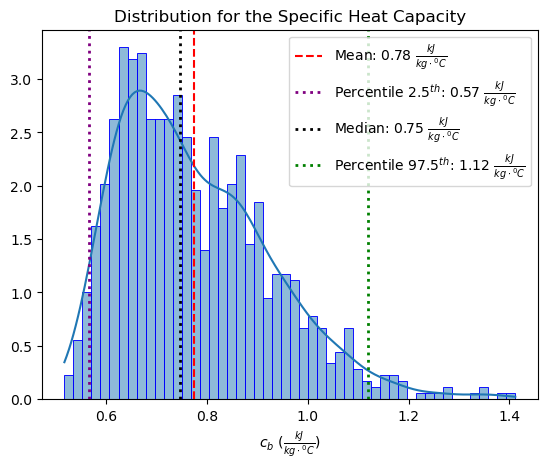

0.7750366721645193

In [24]:
# do a bootstrapping to see where is the average c_b, run multiple jitters and take the avg
# of each heat capacities arrays


def bootstrapping_dist(n, m):
    means_of_means = []
    for j in range(m):
        means = []
        for i in range(n):
            mean = shc_list(df).mean()
            if np.isinf(mean).any() or np.isnan(mean).any():
                i =- 1
            else:
                means.append(mean)
        means_of_means.append(np.mean(means))
    mean_plot = np.mean(means_of_means)
    median_plot = np.median(means_of_means)
    perc_2p5_plot = np.percentile(means_of_means,2.5)
    perc_97p2_plot = np.percentile(means_of_means,97.5)
    sns.histplot(means_of_means, bins=50, stat='density',kde=True, edgecolor='blue')
    plt.axvline(x=mean_plot, linestyle = '--', color = 'red', label=f'Mean: {np.mean(means_of_means):.2f} $\\frac{{kJ}}{{kg\\cdot ^0C}}$')
    plt.axvline(x=perc_2p5_plot, linestyle = ':', color = 'purple', label=f'Percentile 2.5$^{{th}}$: {perc_2p5_plot:.2f} $\\frac{{kJ}}{{kg\\cdot ^0C}}$', linewidth=2)
    plt.axvline(x=median_plot, linestyle = ':', color = 'black', label=f'Median: {median_plot:.2f} $\\frac{{kJ}}{{kg\\cdot ^0C}}$', linewidth=2)
    plt.axvline(x=perc_97p2_plot, linestyle = ':', color = 'green', label=f'Percentile 97.5$^{{th}}$: {perc_97p2_plot:.2f} $\\frac{{kJ}}{{kg\\cdot ^0C}}$', linewidth=2)
    plt.ylabel('')
    plt.xlabel(r'$c_b$ ($\frac{kJ}{kg\cdot ^0C}$)')
    plt.title('Distribution for the Specific Heat Capacity')
    plt.legend()
    plt.savefig(f'Rep 6/populated_mean_specific_heat_capacity.png')
    plt.show()
    return mean_plot
    
n = 100 # n: number of means
m = 1000 # m: number of samples
bootstrapping_dist(n,m)
